# Filter fragments for drug likeness

## Aim of this notebook

This notebook is filtering the fragments for drug likeness. 
* The first filter step checks whether the fragments fulfill the Rule of Three (Ro3) ([Drug Discovery Today, 2003, 8(19):876-877](https://www.sciencedirect.com/science/article/abs/pii/S1359644603028319?via%3Dihub)). 
* The second filter calculates the Quantitative Estimate of Druglikeness (QED) ([Nat Chem. 2012 Jan 24; 4(2): 90–98](https://www.nature.com/articles/nchem.1243)), reflecting the molecular properties of the fragments.

## Table of contents
1. Load fragment library
2. Apply pre-filters
3. Filter for Rule of Three (Ro3)
4. Filter for Quantitative Estimate of Druglikeness (QED)
5. Analyze accepted/rejected fragments

    5.1. Count number of fragments that are accepted by the filter(s)
    
    5.2. Histogram of QED values

## Imports and preprocessing

In [75]:
from pathlib import Path

import pandas as pd
from rdkit.Chem import PandasTools

from kinfraglib import filters, utils

In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global Paths

In [78]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"

## 1. Load fragment library

The fragment library is stored as a dictionary, with the individual subpockets as keys.

In [79]:
fragment_library_original = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [80]:
fragment_library_original.keys()
# NBVAL_CHECK_OUTPUT

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [81]:
pd.concat(fragment_library_original).reset_index(drop=True).shape
# NBVAL_CHECK_OUTPUT

(7486, 15)

## 2. Apply pre-filters
Pre-filters include 
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [82]:
fragment_library = filters.prefilters.pre_filters(fragment_library_original)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,Cc1cc(N)[nH]n1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE]
3,AP,Nc1ncc(C=O)s1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]"
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]"

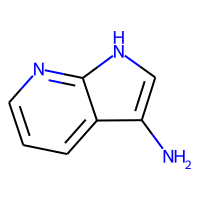
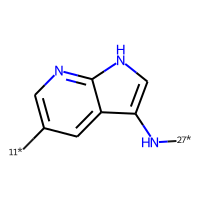
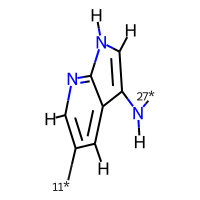
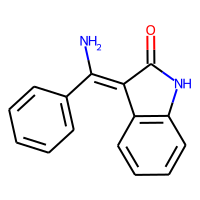
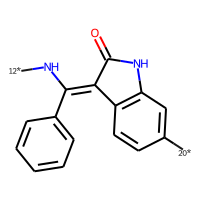
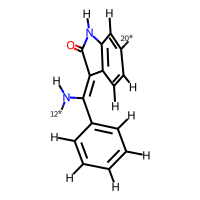
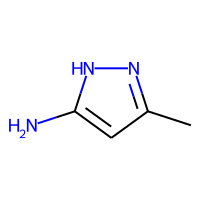
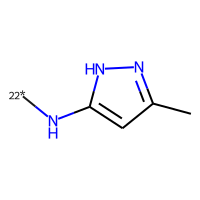
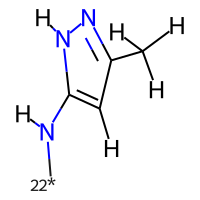
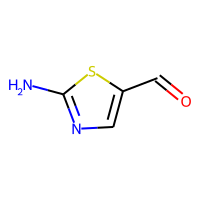
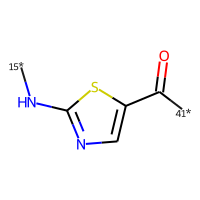
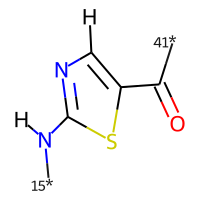
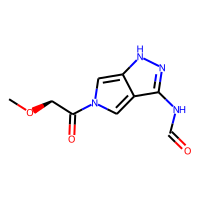
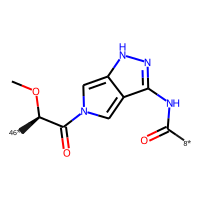
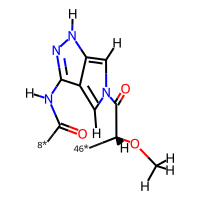

In [83]:
fragment_library["AP"].head()
# NBVAL_CHECK_OUTPUT

Count number of fragments in the original fragment library and after pre-filtering the fragment library.

In [84]:
num_fragments = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library_original, "original"),
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
    ],
    axis=1,
)
num_fragments = pd.concat([num_fragments, pd.Series([num_fragments.sum()], index=["Total"]).rename("Total")])
# NBVAL_CHECK_OUTPUT

Note: The number of fragments in pool X in the original fragment library is not displayed.

## 3. Filter for Rule of Three (Ro3)

The Rule of Three (Ro3) ([Drug Discovery Today, 2003, 8(19):876-877](https://www.sciencedirect.com/science/article/abs/pii/S1359644603028319?via%3Dihub)) is adapted from the Rule of Five (Ro5) ([
J Pharmacol Toxicol Methods, 2000, 44(1): 235-249](https://www.sciencedirect.com/science/article/abs/pii/S1056871900001076?via%3Dihub)) to check if small molecules make good lead compounds.
It is looking at the molecular properties, namely
- molecular weight (MW) <= 300
- number of hydrogen bond acceptor (HBA) <= 3
- number of hydrogen bond donor (HBD) <= 3
- number of rotatable bonds (NROT) <= 3
- polar surface area (PSA) <= 60

In [85]:
filters.drug_likeness.get_ro3_frags?

Signature:
filters.drug_likeness.get_ro3_frags(
    fragment_library,
    min_fulfilled=6,
    cutoff_crit='>=',
)
Docstring:
Check if the fragments fulfill the rule of three criteria
    - molecular weight <300
    - logp <=3
    - number of hydrogen bond acceptors <=3
    - number of hydrogen bond donors <=3
    - number of rotatable bonds <=3
    - polar surface area <= 60

Parameters
----------
fragment_library : dict
    fragments organized in subpockets including all information
min_fulfilled : int
    defining the number of Rule of Three Criteria that need to be fulfilled to be
    accepted. By default min_fulfilled=6.
cutoff_crit : str
    Cutoff criterium, defining if the number of fulfilled parameters is ">" or ">="
    than min_fulfilled. By default cutoff_crit=">=".

Returns
-------
dict
    fragment library organized in subpockets containing a boolean column if they fulfill the
    defined number of Ro3 parameters (bool_ro3).
File:      ~/KinFragLib/kinfraglib/filters/drug

In [86]:
fragment_library = filters.drug_likeness.get_ro3_frags(fragment_library)

Inspect individual subpockets, including the new column if Ro3 fulfilled (`bool_ro3`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_ro3
0,AP,Nc1c[nH]c2ncccc12,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",1
2,AP,Cc1cc(N)[nH]n1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1
3,AP,Nc1ncc(C=O)s1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0

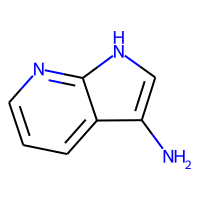
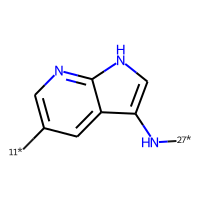
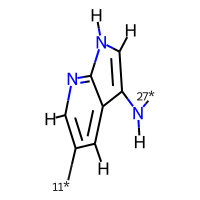
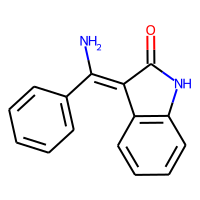
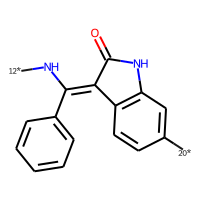
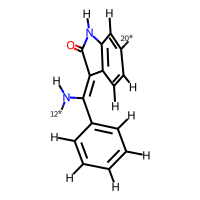
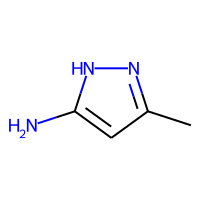
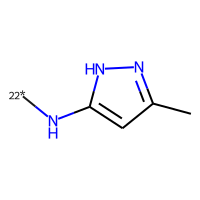
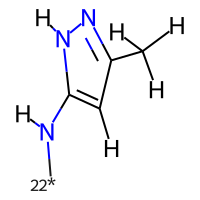
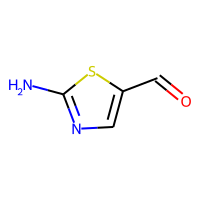
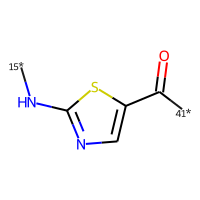
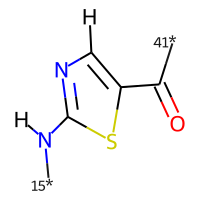
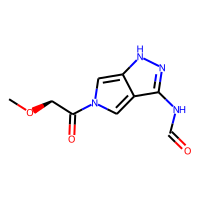
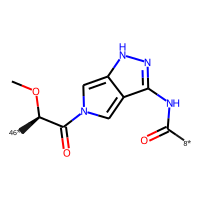
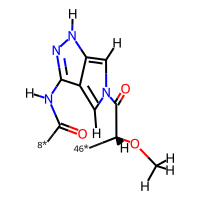

In [87]:
fragment_library["AP"].head()
# NBVAL_CHECK_OUTPUT

Count number of pre-filtered fragments and number of fragments that are accepted and rejected by the Rule of Three filter.

In [88]:
num_fragments_ro3 = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_ro3", "ro3"
        ),
    ],
    axis=1,
)

num_fragments_ro3 = pd.concat(
    [
        num_fragments_ro3,
        pd.DataFrame(num_fragments_ro3.sum().rename("Total")).T
    ],
    axis=0
)
num_fragments_ro3
# NBVAL_CHECK_OUTPUT

,pre_filtered,accepted_ro3,rejected_ro3
AP,1001,516,485
FP,862,653,209
SE,606,500,106
GA,306,278,28
B1,42,39,3
B2,42,40,2
Total,2859,2026,833


## 4. Filter for Quantitative Estimate of Druglikeness (QED)

Quantitative Estimate of Druglikeness (QED) ([Nat Chem. 2012 Jan 24; 4(2): 90–98](https://www.nature.com/articles/nchem.1243)) reflects the distribution of the molecular properties, namely

* molecular weight
* octanol-water-partition-coefficient
* number of hydrogen bond donor and acceptor, 
* polar surface area, 
* number of rotatable bonds, 
* number of aromatic rings 
* and number of structural alerts. 

For each property, a desirability function is used and with them the estimate is calculated.

In [89]:
filters.drug_likeness.get_qed?

Signature:
filters.drug_likeness.get_qed(
    fragment_library,
    cutoff_val=0.492,
    cutoff_crit='>',
)
Docstring:
Calculates the Quantitative Estimate of Druglikeness.

Parameters
----------
fragment_library : dict
    fragments organized in subpockets including all information
cutoff_val : int
    A value defining the cutoff for accepted/rejected fragments. By default, cutoff_val=0.492.
cutoff_crit : str
    Defining whether the QED value should be ">", "<", ">=", "<=", "==" or "!=" compared to
    the cutoff-value. By default ,cutoff_crit=">".

Returns
-------
dict
    Containing a pandas.DataFrame for each subpocket with all fragments and an
    additional columns (bool_qed) defining whether the fragment is accepted (1) or rejected (0)
    and the calculated QED value for each fragment (qed).
File:      ~/KinFragLib/kinfraglib/filters/drug_likeness.py
Type:      function

In [90]:
fragment_library = filters.drug_likeness.get_qed(fragment_library, cutoff_val=0.492)

Inspect individual subpockets, including the new column if QED threshold fulfilled or not per fragment (`bool_qed`) and calculated QED values (`qed`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_ro3,bool_qed,qed
0,AP,Nc1c[nH]c2ncccc12,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",AAK1,NAK,Other,5l4q,LKB,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1,0.565900
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",AAK1,NAK,Other,5te0,XIN,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",1,1,0.747185
2,AP,Cc1cc(N)[nH]n1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",ABL1,Abl,TK,2f4j,VX6,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1,0,0.488854
3,AP,Nc1ncc(C=O)s1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",ABL1,Abl,TK,2gqg,1N1,...,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1,1,0.561340
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",ABL1,Abl,TK,2v7a,627,...,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0,1,0.723961

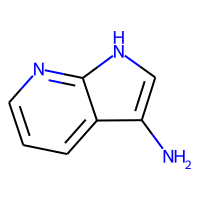
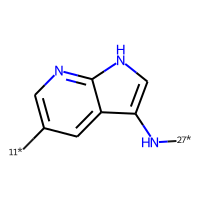
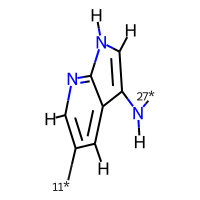
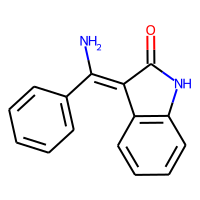
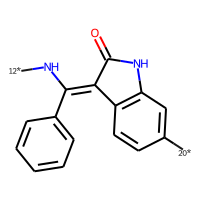
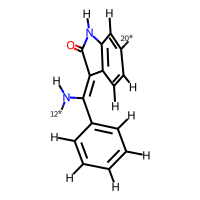
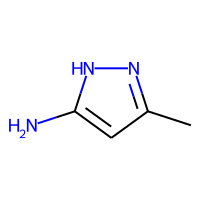
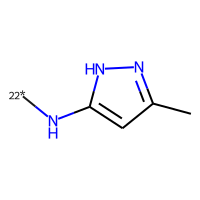
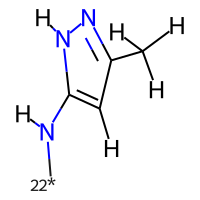
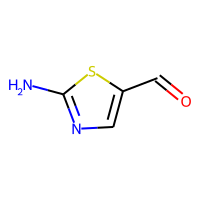
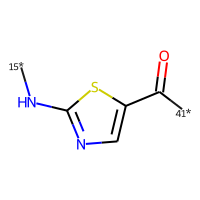
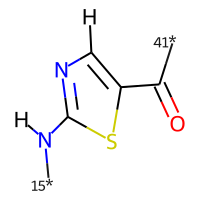
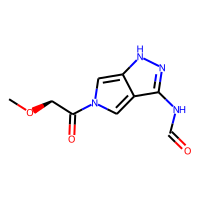
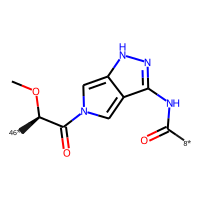
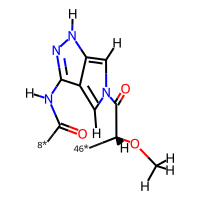

In [91]:
fragment_library["AP"].head()
# NBVAL_CHECK_OUTPUT

Count number of pre-filtered fragments and number of fragments that are accepted and rejected by the QED filter.

In [92]:
num_fragments_qed = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_qed", "qed"
        ),
    ],
    axis=1,
)
num_fragments_qed.append(num_fragments_qed.sum().rename("Total"))
# NBVAL_CHECK_OUTPUT

/tmp/ipykernel_110572/392511540.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  num_fragments_qed.append(num_fragments_qed.sum().rename("Total"))


,pre_filtered,accepted_qed,rejected_qed
subpocket,,,
AP,1001,875,126
FP,862,579,283
SE,606,443,163
GA,306,199,107
B1,42,22,20
B2,42,23,19
Total,2859,2141,718


## 5. Analyze accepted/rejected fragments

    5.1. Count number of fragments that are accepted by the filter(s)

    5.2. Histogram of QED values

### 5.1. Count number of fragments that are accepted by the filter(s)

In [93]:
fragment_library = filters.analysis.number_of_accepted(
    fragment_library, columns=["bool_ro3", "bool_qed"], min_accepted=2
)

In [94]:
filters.analysis.accepted_num_filters(
    fragment_library,
    ["bool_qed", "bool_ro3"],
    filtername="drug likeness filters",
    max_num_accepted=2,
)

,pre-filtered,accepted by 2,accepted by 1,accepted by 0
AP,1001,456,479,66
FP,862,414,404,44
SE,606,354,235,17
GA,306,182,113,11
B1,42,20,21,1
B2,42,22,19,1
Total,2859,1448,1271,140


### 5.2. Histogram of QED values
Create a histogram for each subpocket showing the QED values and the chosen threshold.

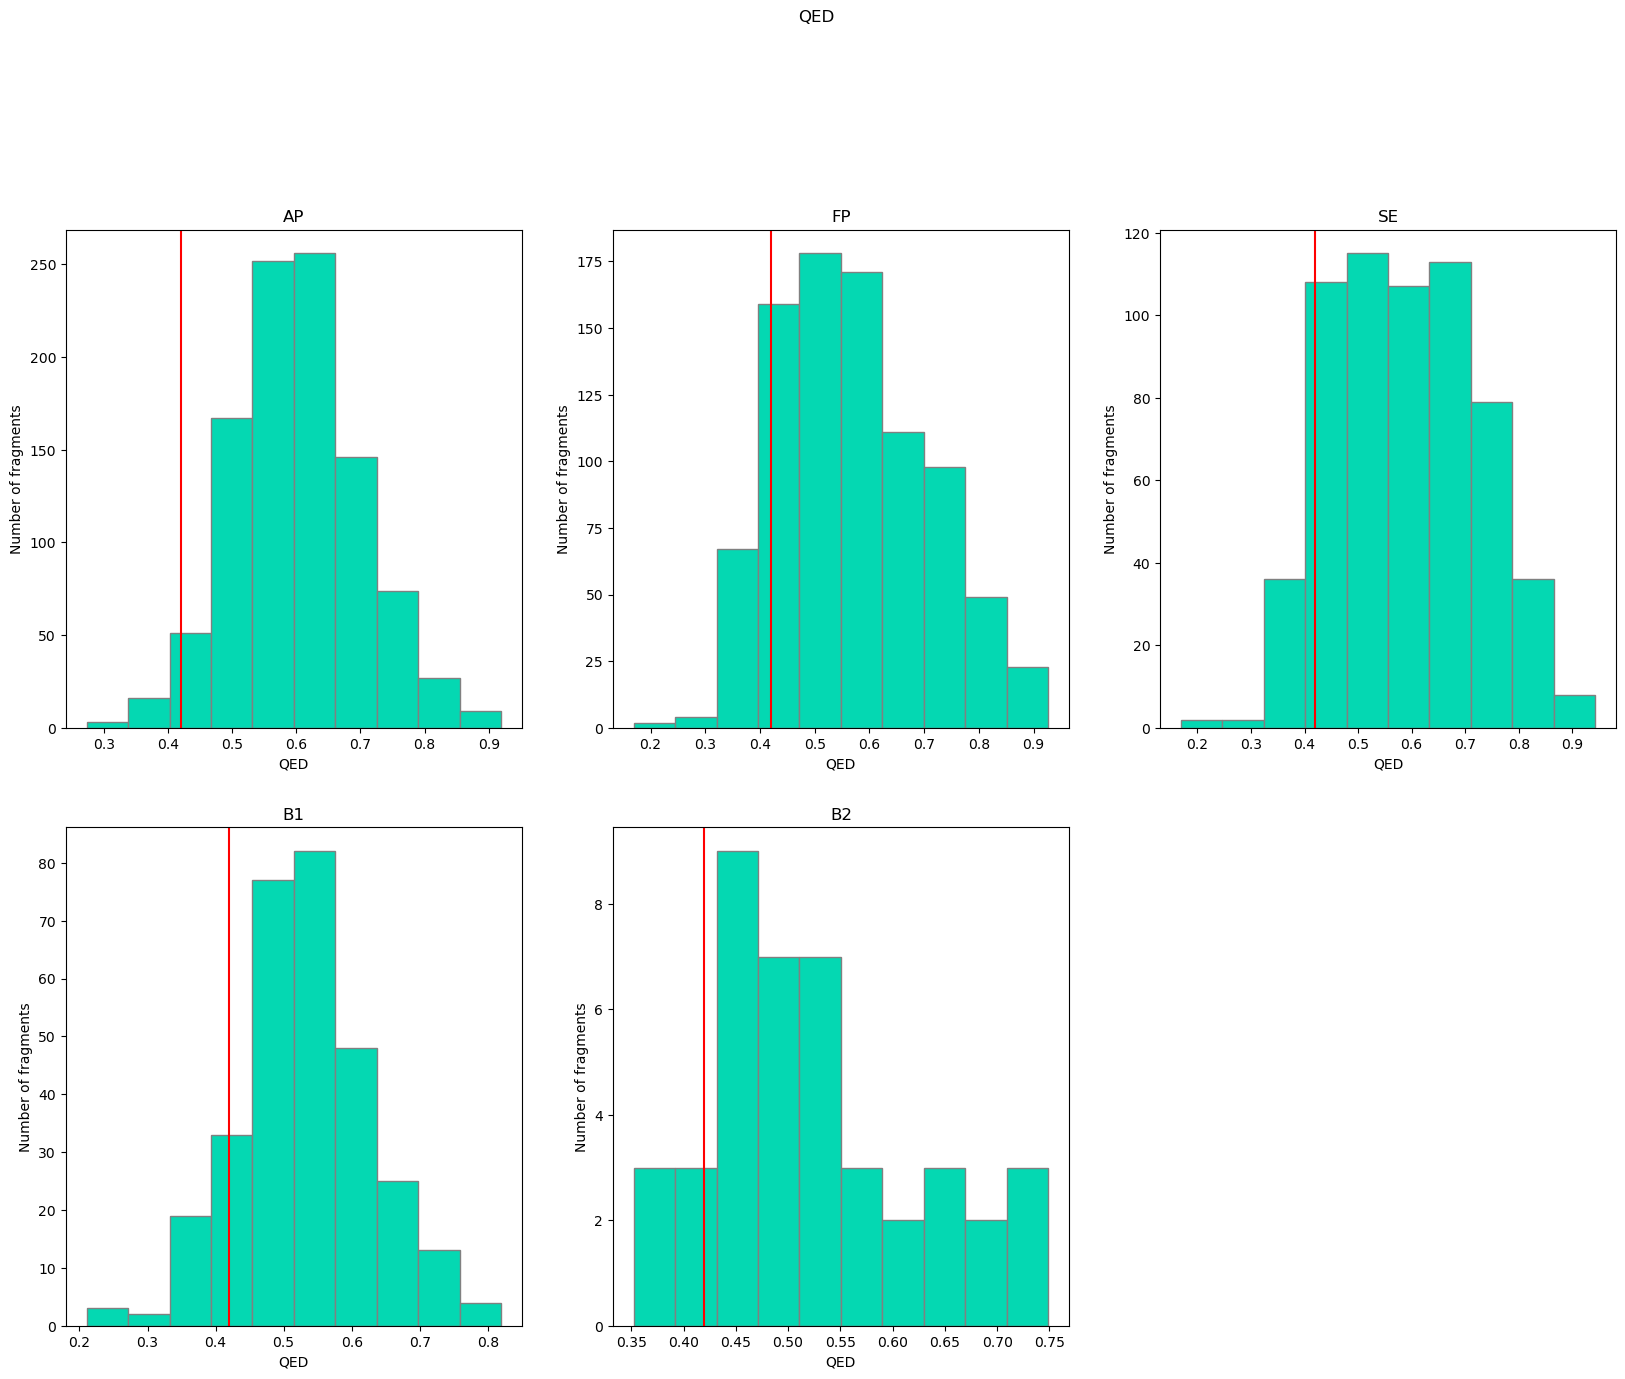

In [95]:
filters.plots.make_hists(
    fragment_library, "qed", "QED", plot_stats=False, cutoff=0.42
)